In [1]:
!pip3 install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 53.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 104.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 30.8 MB/s eta 0:00:00


In [2]:
!pip install -q bitsandbytes datasets accelerate
!pip install -q git+https://github.com/huggingface/transformers.git@main git+https://github.com/huggingface/peft.git@main

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
!pwd

/content


In [4]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import re
import copy
from tqdm.notebook import tqdm
import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)

from transformers import (
    T5Tokenizer,
    T5Model,
    T5ForConditionalGeneration,
    get_linear_schedule_with_warmup
)

project_dir = './'

In [5]:
! nvidia-smi

Sat Oct 28 20:48:46 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
df = pd.read_csv(project_dir + 'full_data.csv')
df.head()

,ID,Text,Reconnaissance,Resource Development,Initial Access,Execution,Persistence,Privilege Escalation,Defense Evasion,Credential Access,Discovery,Lateral Movement,Collection,Command and Control,Exfiltration,Impact
0,CVE-2020-5421,"In Spring Framework versions 5.2.0 - 5.2.8, 5....",0,0,0,1,0,1,0,1,0,0,1,0,0,0
1,CVE-2020-5413,Spring Integration framework provides Kryo Cod...,0,0,1,1,0,1,0,0,0,0,0,0,0,0
2,CVE-2020-28035,WordPress before 5.5.2 allows attackers to gai...,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,CVE-2017-13715,The __skb_flow_dissect function in net/core/fl...,0,0,0,1,0,0,1,0,0,0,0,0,0,1
4,CVE-2014-2523,net/netfilter/nf_conntrack_proto_dccp.c in the...,0,0,0,1,0,0,1,0,0,0,0,0,0,1


In [7]:
df = df.rename(columns={'Resource Development': 'Resources'})
df = df.rename(columns={'Initial Access': 'Access'})
df = df.rename(columns={'Privilege Escalation': 'Escalation'})
df = df.rename(columns={'Defense Evasion': 'Evasion'})
df = df.rename(columns={'Credential Access': 'Credentials'})
df = df.rename(columns={'Lateral Movement': 'Movement'})
df = df.rename(columns={'Command and Control': 'Control'})

df.head()

,ID,Text,Reconnaissance,Resources,Access,Execution,Persistence,Escalation,Evasion,Credentials,Discovery,Movement,Collection,Control,Exfiltration,Impact
0,CVE-2020-5421,"In Spring Framework versions 5.2.0 - 5.2.8, 5....",0,0,0,1,0,1,0,1,0,0,1,0,0,0
1,CVE-2020-5413,Spring Integration framework provides Kryo Cod...,0,0,1,1,0,1,0,0,0,0,0,0,0,0
2,CVE-2020-28035,WordPress before 5.5.2 allows attackers to gai...,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,CVE-2017-13715,The __skb_flow_dissect function in net/core/fl...,0,0,0,1,0,0,1,0,0,0,0,0,0,1
4,CVE-2014-2523,net/netfilter/nf_conntrack_proto_dccp.c in the...,0,0,0,1,0,0,1,0,0,0,0,0,0,1


In [8]:
tactics = df.columns[2:]
df_filtered = df.drop(df[(df[tactics] == 0).all(axis=1)].index)

df = df_filtered

In [9]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

final_texts = []
final_labels = []

def clean_abstract(text):
    # Replace versions with the word "VERSION"
    version_pattern = r"\d+(\.\d+)+"
    updated_text = re.sub(version_pattern, "version", text)

    # Replace other CVE references
    version_pattern = r'CVE-\d{1,5}-\d{1,5}'
    updated_text = re.sub(version_pattern, "CVE", updated_text)

    return updated_text

def get_texts(df):
    texts = df['Text'].apply(clean_abstract)
    texts = texts.values.tolist()
    return texts

def get_labels(df):
    labels_li = [' '.join(x.lower().split()) for x in df.columns.to_list()[2:]]
    labels_matrix = np.array([labels_li] * len(df))

    mask = df.iloc[:, 2:].values.astype(bool)
    labels = []
    for l, m in zip(labels_matrix, mask):
        x = l[m]
        if len(x) > 0:
            labels.append((x.tolist()))

    return labels

texts = get_texts(df)
labels = get_labels(df)

print(type(texts))
print(type(labels))

print(type(texts[0]))
print(type(labels[0]))

print(len(texts))
print(len(labels))

for text, label in zip(texts[:5], labels[:5]):
    print(f'TEXT -\t{text}')
    print(f'LABEL -\t{label}')
    print()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


<class 'list'>
<class 'list'>
<class 'str'>
<class 'list'>
1718
1718
TEXT -	In Spring Framework versions version - version, version - version, version - version, version - version, and older unsupported versions, the protections against RFD attacks from CVE may be bypassed depending on the browser used through the use of a jsessionid path parameter
LABEL -	['execution', 'escalation', 'credentials', 'collection']

TEXT -	Spring Integration framework provides Kryo Codec implementations as an alternative for Java (de)serialization. When Kryo is configured with default options, all unregistered classes are resolved on demand. This leads to the "deserialization gadgets" exploit when provided data contains malicious code for execution during deserialization. In order to protect against this type of attack, Kryo can be configured to require a set of trusted classes for (de)serialization. Spring Integration should be proactive against blocking unknown "deserialization gadgets" when configuring

# Exploratory Data Analysis

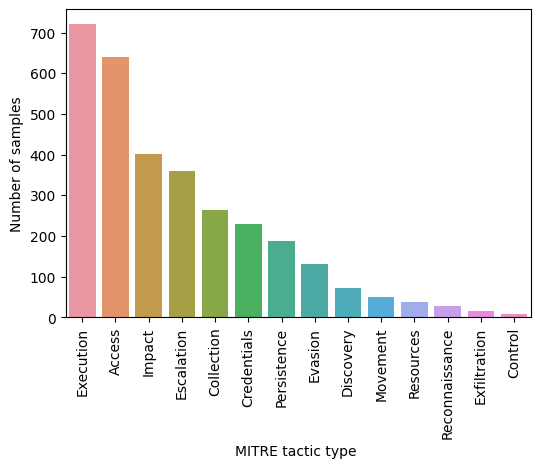

In [10]:
categories = df.iloc[:, 2:].sum()
plt.figure(figsize=(6, 4))

sorted_categories = categories.sort_values(ascending=False).index
ax = sns.barplot(x=sorted_categories, y=categories[sorted_categories].values)

plt.ylabel('Number of samples')
plt.xlabel('MITRE tactic type ')
plt.xticks(rotation=90)
plt.show()

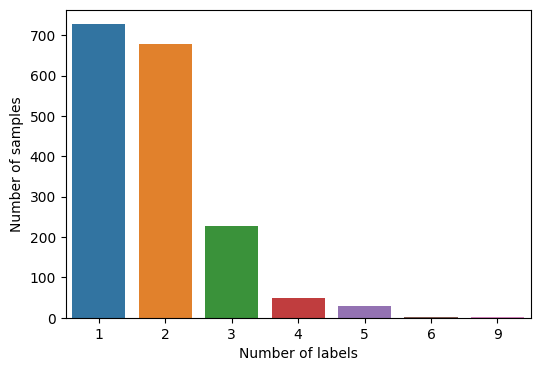

In [11]:
row_sums = df.iloc[:, 2:].sum(axis=1)
multilabel_counts = row_sums.value_counts()

plt.figure(figsize=(6, 4))
ax = sns.barplot(x=multilabel_counts.index, y=multilabel_counts.values)
plt.ylabel('Number of samples')
plt.xlabel('Number of labels')
plt.show()

<BarContainer object of 1718 artists>

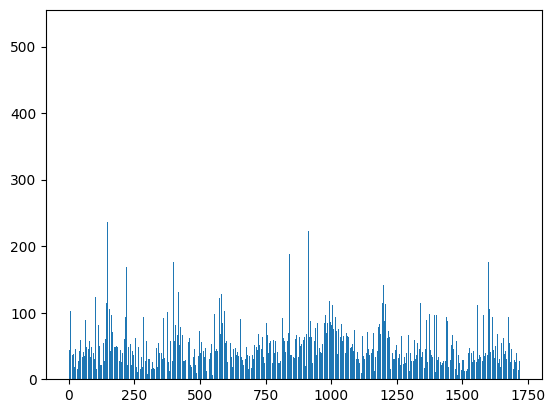

In [12]:
y = [len(t.split()) for t in texts]
x = range(0, len(y))
plt.bar(x, y)

# Config

In [13]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
!pip3 install transformers
!pip install transformers[sentencepiece] datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.1 MB/s eta 0:00:00


In [14]:
from datasets import load_dataset
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

class Config:
    def __init__(self):
        super(Config, self).__init__()

        self.SEED = 42
        self.MODEL_PATH = 'google/flan-t5-base'

        self.TOKENIZER = AutoTokenizer.from_pretrained(self.MODEL_PATH)
        self.SRC_MAX_LENGTH = 320
        self.TGT_MAX_LENGTH = 20
        self.BATCH_SIZE = 16
        self.VALIDATION_SPLIT = 0.20

        self.DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.FULL_FINETUNING = True
        self.LR = 3e-3
        self.OPTIMIZER = 'AdamW'
        self.SAVE_BEST_ONLY = True
        self.N_VALIDATE_DUR_TRAIN = 3
        self.EPOCHS = 5

config = Config()

# Dataset & Dataloader

In [15]:
class T5Dataset(Dataset):
    def __init__(self, df, set_type=None, custom_type=None):
        super(T5Dataset, self).__init__()

        self.texts = get_texts(df)
        self.set_type = set_type

        labels_df = df['label'].tolist()
        self.labels = [x + ' </s>' for x in labels_df]

        self.tokenizer = config.TOKENIZER
        self.src_max_length = config.SRC_MAX_LENGTH
        self.tgt_max_length = config.TGT_MAX_LENGTH

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        src_tokenized = self.tokenizer.encode_plus(
            self.texts[index],
            max_length=self.src_max_length,
            pad_to_max_length=True,
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )
        src_input_ids = src_tokenized['input_ids'].squeeze()
        src_attention_mask = src_tokenized['attention_mask'].squeeze()

        if self.set_type != 'test':
            tgt_tokenized = self.tokenizer.encode_plus(
                self.labels[index],
                max_length=self.tgt_max_length,
                pad_to_max_length=True,
                truncation=True,
                return_attention_mask=True,
                return_token_type_ids=False,
                return_tensors='pt'
            )
            tgt_input_ids = tgt_tokenized['input_ids'].squeeze()
            tgt_attention_mask = tgt_tokenized['attention_mask'].squeeze()

            return {
                'src_input_ids': src_input_ids.long(),
                'src_attention_mask': src_attention_mask.long(),
                'tgt_input_ids': tgt_input_ids.long(),
                'tgt_attention_mask': tgt_attention_mask.long()
            }

        return {
            'src_input_ids': src_input_ids.long(),
            'src_attention_mask': src_attention_mask.long()
        }

In [16]:
df_train = pd.read_csv(project_dir + 'train_data.csv')
print(df_train.shape)
df_train.head()

(1387, 16)


,ID,Text,Reconnaissance,Resource Development,Initial Access,Execution,Persistence,Privilege Escalation,Defense Evasion,Credential Access,Discovery,Lateral Movement,Collection,Command and Control,Exfiltration,Impact
0,CVE-2020-15100,"In freewvs before 0.1.1, a user could create a...",0,0,1,0,1,0,0,0,0,0,0,0,0,1
1,CVE-2017-0262,"Microsoft Office 2010 SP2, Office 2013 SP1, an...",0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,CVE-2021-33709,A vulnerability has been identified in Teamcen...,0,0,0,1,0,0,0,1,0,0,0,0,0,0
3,CVE-2021-3393,An information leak was discovered in postgres...,0,0,0,1,0,0,0,0,0,0,1,0,0,0
4,CVE-2022-26850,When creating or updating credentials for sing...,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [17]:
df_train = df_train.rename(columns={'Resource Development': 'Resources'})
df_train = df_train.rename(columns={'Initial Access': 'Access'})
df_train = df_train.rename(columns={'Privilege Escalation': 'Escalation'})
df_train = df_train.rename(columns={'Defense Evasion': 'Evasion'})
df_train = df_train.rename(columns={'Credential Access': 'Credentials'})
df_train = df_train.rename(columns={'Lateral Movement': 'Movement'})
df_train = df_train.rename(columns={'Command and Control': 'Control'})

df_train.head()

,ID,Text,Reconnaissance,Resources,Access,Execution,Persistence,Escalation,Evasion,Credentials,Discovery,Movement,Collection,Control,Exfiltration,Impact
0,CVE-2020-15100,"In freewvs before 0.1.1, a user could create a...",0,0,1,0,1,0,0,0,0,0,0,0,0,1
1,CVE-2017-0262,"Microsoft Office 2010 SP2, Office 2013 SP1, an...",0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,CVE-2021-33709,A vulnerability has been identified in Teamcen...,0,0,0,1,0,0,0,1,0,0,0,0,0,0
3,CVE-2021-3393,An information leak was discovered in postgres...,0,0,0,1,0,0,0,0,0,0,1,0,0,0
4,CVE-2022-26850,When creating or updating credentials for sing...,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [18]:
df_test = pd.read_csv(project_dir + 'test_data.csv')
print(df_test.shape)
df_test.head()

(331, 16)


,ID,Text,Reconnaissance,Resource Development,Initial Access,Execution,Persistence,Privilege Escalation,Defense Evasion,Credential Access,Discovery,Lateral Movement,Collection,Command and Control,Exfiltration,Impact
0,CVE-2021-34803,TeamViewer before 14.7.48644 on Windows loads ...,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,CVE-2016-0034,Microsoft Silverlight 5 before 5.1.41212.0 mis...,0,0,1,1,0,0,0,0,0,0,0,0,0,1
2,CVE-2015-5123,Use-after-free vulnerability in the BitmapData...,0,0,1,1,0,0,0,0,0,0,0,0,0,0
3,CVE-2021-23964,Mozilla developers reported memory safety bugs...,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,CVE-2020-5812,Nessus AMI versions 8.12.0 and earlier were fo...,0,0,1,0,0,0,0,1,0,0,1,0,0,0


In [19]:
df_test = df_test.rename(columns={'Resource Development': 'Resources'})
df_test = df_test.rename(columns={'Initial Access': 'Access'})
df_test = df_test.rename(columns={'Privilege Escalation': 'Escalation'})
df_test = df_test.rename(columns={'Defense Evasion': 'Evasion'})
df_test = df_test.rename(columns={'Credential Access': 'Credentials'})
df_test = df_test.rename(columns={'Lateral Movement': 'Movement'})
df_test = df_test.rename(columns={'Command and Control': 'Control'})

df_test.head()

,ID,Text,Reconnaissance,Resources,Access,Execution,Persistence,Escalation,Evasion,Credentials,Discovery,Movement,Collection,Control,Exfiltration,Impact
0,CVE-2021-34803,TeamViewer before 14.7.48644 on Windows loads ...,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,CVE-2016-0034,Microsoft Silverlight 5 before 5.1.41212.0 mis...,0,0,1,1,0,0,0,0,0,0,0,0,0,1
2,CVE-2015-5123,Use-after-free vulnerability in the BitmapData...,0,0,1,1,0,0,0,0,0,0,0,0,0,0
3,CVE-2021-23964,Mozilla developers reported memory safety bugs...,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,CVE-2020-5812,Nessus AMI versions 8.12.0 and earlier were fo...,0,0,1,0,0,0,0,1,0,0,1,0,0,0


In [ ]:
new_columns = df_train.columns[2:]
new_label = df_train[new_columns].apply(lambda x: ', '.join(new_columns[x == 1]), axis=1)

train_df_extended = pd.DataFrame({'ID': df_train['ID'], 'Text': "CVE Text: " + df_train['Text'], 'label': "Predicted MITRE tactics: " + new_label})

train_df_extended.head()

In [21]:
new_columns = df_test.columns[2:]
new_label = df_test[new_columns].apply(lambda x: ', '.join(new_columns[x == 1]), axis=1)

test_df_extended = pd.DataFrame({'ID': df_test['ID'], 'Text': "CVE Text: " + df_test['Text'], 'label': "Predicted MITRE tactics: " + new_label})

test_df_extended.head()

,ID,Text,label
0,CVE-2021-34803,CVE Text: TeamViewer before 14.7.48644 on Wind...,Predicted MITRE tactics: Execution
1,CVE-2016-0034,CVE Text: Microsoft Silverlight 5 before 5.1.4...,"Predicted MITRE tactics: Access, Execution, Im..."
2,CVE-2015-5123,CVE Text: Use-after-free vulnerability in the ...,"Predicted MITRE tactics: Access, Execution"
3,CVE-2021-23964,CVE Text: Mozilla developers reported memory s...,Predicted MITRE tactics: Execution
4,CVE-2020-5812,CVE Text: Nessus AMI versions 8.12.0 and earli...,"Predicted MITRE tactics: Access, Credentials, ..."


In [22]:
train_data = T5Dataset(train_df_extended, custom_type="train")
val_data = T5Dataset(test_df_extended, custom_type="validation")

train_dataloader = DataLoader(train_data, batch_size=config.BATCH_SIZE)
val_dataloader = DataLoader(val_data, batch_size=config.BATCH_SIZE)

b = next(iter(train_dataloader))
for k, v in b.items():
    print(f'{k} shape: {v.shape}')

src_input_ids shape: torch.Size([16, 320])
src_attention_mask shape: torch.Size([16, 320])
tgt_input_ids shape: torch.Size([16, 20])
tgt_attention_mask shape: torch.Size([16, 20])


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


# Model

In [23]:
from peft import prepare_model_for_int8_training
from peft import LoraConfig, get_peft_model, TaskType

def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )


class T5Model(nn.Module):
    def __init__(self):
        super(T5Model, self).__init__()

        self.t5_model = AutoModelForSeq2SeqLM.from_pretrained(config.MODEL_PATH, load_in_8bit=True)
        self.t5_model = prepare_model_for_int8_training(self.t5_model)

        lora_config = LoraConfig(r=16, lora_alpha=32, target_modules=["q", "v", "k", "o"], lora_dropout=0.05, bias="none", task_type="SEQ_2_SEQ_LM")


        self.t5_model = get_peft_model(self.t5_model, lora_config)
        print_trainable_parameters(self.t5_model)

    def forward(
        self,
        input_ids,
        attention_mask=None,
        decoder_input_ids=None,
        decoder_attention_mask=None,
        labels=None
        ):

        return self.t5_model(
            input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            labels=labels,
        )

In [24]:
device = config.DEVICE
device

device(type='cuda')

# Engine

In [25]:
def compute_metrics(predicted_y, true_y, metric_function, columns, limit):
  results = pd.DataFrame(columns = columns)
  if (metric_function == accuracy_score):
    results.loc[len(results)] = metric_function(true_y, predicted_y)
  else:
    results.loc[len(results)] = metric_function(true_y, predicted_y, average=None)

  sorted_results = results.sort_values(by=0, axis=1, ascending=False)

  sorted_results.head()
  return sorted_results.iloc[:, :limit]

def print_F1_based_on_distribution(y_true, y_pred, Y, columns):
  fig,ax = plt.subplots()

  results = pd.DataFrame(columns = columns)
  results.loc[len(results)] = f1_score(y_true, y_pred, average=None)

  Y_count = Y.apply(np.sum, axis=0)
  Y_count_sorted = Y_count.sort_values(ascending=False)

  ax.bar(Y_count_sorted.index, Y_count_sorted.values)
  ax.set_xlabel("Tactics")
  ax.set_ylabel("Number of CVEs")
  plt.xticks(rotation=90)

  ax2=ax.twinx()
  ax2.plot(Y_count_sorted.index, results[Y_count_sorted.index].iloc[0], color='red')
  ax2.set_ylabel("F1 Score")

  ax = plt.gca()
  plt.show()

In [26]:
def get_ohe(sequences):
    labels_to_idx = dict()
    label_names = df_test.columns.to_list()[2:]
    for idx, label in enumerate(label_names):
        labels_to_idx[label] = idx

    ohe = []
    for seq in sequences:
        current_ohe = [0] * 14

        processed_seq = seq.replace("Predicted MITRE tactics:", "")
        processed_seq = processed_seq.replace("</s>", "")
        processed_seq = processed_seq.replace("<pad>", "")
        processed_seq = processed_seq.replace(" ", "")
        labels = processed_seq.split(',')

        for label in labels:
            idx = labels_to_idx.get(label, -1)
            if idx != -1:
                current_ohe[idx] = 1

        ohe.append(current_ohe)

    ohe = np.array(ohe)
    return ohe

In [27]:
BEST_F1 = 0
BEST_TRUE = []
BEST_PREDICTED = []

def val(model, val_dataloader):
    global BEST_F1, BEST_TRUE, BEST_PREDICTED

    val_loss = 0
    true, pred = [], []

    model.eval()

    for step, batch in enumerate(val_dataloader):
        b_src_input_ids = batch['src_input_ids'].to(device)
        b_src_attention_mask = batch['src_attention_mask'].to(device)

        b_tgt_input_ids = batch['tgt_input_ids']
        labels = b_tgt_input_ids.to(device)
        labels[labels[:, :] == config.TOKENIZER.pad_token_id] = -100

        b_tgt_attention_mask = batch['tgt_attention_mask'].to(device)

        with torch.no_grad():
            outputs = model(
                input_ids=b_src_input_ids,
                attention_mask=b_src_attention_mask,
                labels=labels,
                decoder_attention_mask=b_tgt_attention_mask)
            loss = outputs[0]

            val_loss += loss.item()

            for true_id in b_tgt_input_ids:
                true_decoded = config.TOKENIZER.decode(true_id)
                true.append(true_decoded)

            pred_ids = model.t5_model.generate(
                input_ids=b_src_input_ids,
                attention_mask=b_src_attention_mask,
            )

            pred_ids = pred_ids.cpu().numpy()
            for pred_id in pred_ids:
                pred_decoded = config.TOKENIZER.decode(pred_id)
                pred.append(pred_decoded)

    true_ohe = get_ohe(true)
    pred_ohe = get_ohe(pred)

    print(true)
    print(pred)

    print(true_ohe)
    print(pred_ohe)

    avg_val_loss = val_loss / len(val_dataloader)
    print('Val loss:', avg_val_loss)
    print('Val accuracy:', accuracy_score(true_ohe, pred_ohe))

    print('Val precision:', precision_score(true_ohe, pred_ohe, average='weighted'))
    print('Val recall:', recall_score(true_ohe, pred_ohe, average='weighted'))

    val_micro_f1_score = f1_score(true_ohe, pred_ohe, average='micro')
    print('Val micro f1 score:', val_micro_f1_score)

    val_macro_f1_score = f1_score(true_ohe, pred_ohe, average='macro')
    print('Val macro f1 score:', val_macro_f1_score)

    val_weighted_f1_score = f1_score(true_ohe, pred_ohe, average='weighted')
    print('Val weighted f1 score:', val_weighted_f1_score)

    if (val_weighted_f1_score > BEST_F1):
      BEST_F1 = val_weighted_f1_score
      BEST_TRUE = true_ohe
      BEST_PREDICTED = pred_ohe

    return val_weighted_f1_score


def train(
    model,
    train_dataloader,
    val_dataloader,
    optimizer,
    scheduler,
    epoch
    ):

    nv = config.N_VALIDATE_DUR_TRAIN
    temp = len(train_dataloader) // nv
    temp = temp - (temp % 100)
    validate_at_steps = [temp * x for x in range(1, nv + 1)]

    train_loss = 0
    for step, batch in enumerate(tqdm(train_dataloader,
                                      desc='Epoch ' + str(epoch))):
        model.train()

        b_src_input_ids = batch['src_input_ids'].to(device)
        b_src_attention_mask = batch['src_attention_mask'].to(device)

        labels = batch['tgt_input_ids'].to(device)
        labels[labels[:, :] == config.TOKENIZER.pad_token_id] = -100

        b_tgt_attention_mask = batch['tgt_attention_mask'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids=b_src_input_ids,
                        attention_mask=b_src_attention_mask,
                        labels=labels,
                        decoder_attention_mask=b_tgt_attention_mask)
        loss = outputs[0]
        train_loss += loss.item()

        loss.backward()

        optimizer.step()

        scheduler.step()

        if step in validate_at_steps:
            print(f'-- Step: {step}')
            _ = val(model, val_dataloader)

    avg_train_loss = train_loss / len(train_dataloader)
    print('Training loss:', avg_train_loss)

# Run

In [28]:
def run():
    torch.manual_seed(config.SEED)

    if config.FULL_FINETUNING:
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {
                "params": [
                    p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.001,
            },
            {
                "params": [
                    p for n, p in param_optimizer if any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.0,
            },
        ]
        optimizer = optim.AdamW(optimizer_parameters, lr=config.LR)

    num_training_steps = len(train_dataloader) * config.EPOCHS
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps
    )

    max_val_weighted_f1_score = float('-inf')
    for epoch in range(config.EPOCHS):
        train(model, train_dataloader, val_dataloader, optimizer, scheduler, epoch)
        val_weighted_f1_score = val(model, val_dataloader)

        if config.SAVE_BEST_ONLY:
            if val_weighted_f1_score > max_val_weighted_f1_score:
                best_model = copy.deepcopy(model)

                model_name = 't5_best_model'
                torch.save(best_model.state_dict(), model_name + '.pt')

                print(f'--- Best Model. F1: {max_val_weighted_f1_score} -> {val_weighted_f1_score}')
                max_val_weighted_f1_score = val_weighted_f1_score

    return best_model, max_val_weighted_f1_score

In [29]:
import os
import torch

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [30]:
model = T5Model()
model.to(device);

/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:107: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(


trainable params: 3538944 || all params: 251116800 || trainable%: 1.4092820552029972


In [31]:
best_model, best_val_weighted_f1_score = run()

Epoch 0:   0%|          | 0/87 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


-- Step: 0


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['Predicted MITRE tactics: Execution </s></s><pad><pad><pad><pad><pad><pad><pad>', 'Predicted MITRE tactics: Access, Execution, Impact </s></s><pad><pad><pad>', 'Predicted MITRE tactics: Access, Execution </s></s><pad><pad><pad><pad><pad>', 'Predicted MITRE tactics: Execution </s></s><pad><pad><pad><pad><pad><pad><pad>', 'Predicted MITRE tactics: Access, Credentials, Collection </s></s><pad><pad><pad>', 'Predicted MITRE tactics: Access, Evasion </s></s><pad><pad><pad><pad><pad><pad>', 'Predicted MITRE tactics: Impact </s></s><pad><pad><pad><pad><pad><pad><pad><pad><pad>', 'Predicted MITRE tactics: Access, Execution, Persistence, Impact </s></s>', 'Predicted MITRE tactics: Evasion, Credentials </s></s><pad><pad><pad><pad>', 'Predicted MITRE tactics: Credentials </s></s><pad><pad><pad><pad><pad><pad><pad>', 'Predicted MITRE tactics: Execution, Movement, Collection </s></s><pad><pad><pad>', 'Predicted MITRE tactics: Execution, Persistence, Impact </s></s><pad><pad>', 'Predicted MITRE tact

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicit

Training loss: 0.70656501698768


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['Predicted MITRE tactics: Execution </s></s><pad><pad><pad><pad><pad><pad><pad>', 'Predicted MITRE tactics: Access, Execution, Impact </s></s><pad><pad><pad>', 'Predicted MITRE tactics: Access, Execution </s></s><pad><pad><pad><pad><pad>', 'Predicted MITRE tactics: Execution </s></s><pad><pad><pad><pad><pad><pad><pad>', 'Predicted MITRE tactics: Access, Credentials, Collection </s></s><pad><pad><pad>', 'Predicted MITRE tactics: Access, Evasion </s></s><pad><pad><pad><pad><pad><pad>', 'Predicted MITRE tactics: Impact </s></s><pad><pad><pad><pad><pad><pad><pad><pad><pad>', 'Predicted MITRE tactics: Access, Execution, Persistence, Impact </s></s>', 'Predicted MITRE tactics: Evasion, Credentials </s></s><pad><pad><pad><pad>', 'Predicted MITRE tactics: Credentials </s></s><pad><pad><pad><pad><pad><pad><pad>', 'Predicted MITRE tactics: Execution, Movement, Collection </s></s><pad><pad><pad>', 'Predicted MITRE tactics: Execution, Persistence, Impact </s></s><pad><pad>', 'Predicted MITRE tact

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--- Best Model. F1: -inf -> 0.3240751340660098


Epoch 1:   0%|          | 0/87 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/py

-- Step: 0


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['Predicted MITRE tactics: Execution </s></s><pad><pad><pad><pad><pad><pad><pad>', 'Predicted MITRE tactics: Access, Execution, Impact </s></s><pad><pad><pad>', 'Predicted MITRE tactics: Access, Execution </s></s><pad><pad><pad><pad><pad>', 'Predicted MITRE tactics: Execution </s></s><pad><pad><pad><pad><pad><pad><pad>', 'Predicted MITRE tactics: Access, Credentials, Collection </s></s><pad><pad><pad>', 'Predicted MITRE tactics: Access, Evasion </s></s><pad><pad><pad><pad><pad><pad>', 'Predicted MITRE tactics: Impact </s></s><pad><pad><pad><pad><pad><pad><pad><pad><pad>', 'Predicted MITRE tactics: Access, Execution, Persistence, Impact </s></s>', 'Predicted MITRE tactics: Evasion, Credentials </s></s><pad><pad><pad><pad>', 'Predicted MITRE tactics: Credentials </s></s><pad><pad><pad><pad><pad><pad><pad>', 'Predicted MITRE tactics: Execution, Movement, Collection </s></s><pad><pad><pad>', 'Predicted MITRE tactics: Execution, Persistence, Impact </s></s><pad><pad>', 'Predicted MITRE tact

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicit

Training loss: 0.3167574624905641


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['Predicted MITRE tactics: Execution </s></s><pad><pad><pad><pad><pad><pad><pad>', 'Predicted MITRE tactics: Access, Execution, Impact </s></s><pad><pad><pad>', 'Predicted MITRE tactics: Access, Execution </s></s><pad><pad><pad><pad><pad>', 'Predicted MITRE tactics: Execution </s></s><pad><pad><pad><pad><pad><pad><pad>', 'Predicted MITRE tactics: Access, Credentials, Collection </s></s><pad><pad><pad>', 'Predicted MITRE tactics: Access, Evasion </s></s><pad><pad><pad><pad><pad><pad>', 'Predicted MITRE tactics: Impact </s></s><pad><pad><pad><pad><pad><pad><pad><pad><pad>', 'Predicted MITRE tactics: Access, Execution, Persistence, Impact </s></s>', 'Predicted MITRE tactics: Evasion, Credentials </s></s><pad><pad><pad><pad>', 'Predicted MITRE tactics: Credentials </s></s><pad><pad><pad><pad><pad><pad><pad>', 'Predicted MITRE tactics: Execution, Movement, Collection </s></s><pad><pad><pad>', 'Predicted MITRE tactics: Execution, Persistence, Impact </s></s><pad><pad>', 'Predicted MITRE tact

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--- Best Model. F1: 0.3240751340660098 -> 0.47349621632130046


Epoch 2:   0%|          | 0/87 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/py

-- Step: 0


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['Predicted MITRE tactics: Execution </s></s><pad><pad><pad><pad><pad><pad><pad>', 'Predicted MITRE tactics: Access, Execution, Impact </s></s><pad><pad><pad>', 'Predicted MITRE tactics: Access, Execution </s></s><pad><pad><pad><pad><pad>', 'Predicted MITRE tactics: Execution </s></s><pad><pad><pad><pad><pad><pad><pad>', 'Predicted MITRE tactics: Access, Credentials, Collection </s></s><pad><pad><pad>', 'Predicted MITRE tactics: Access, Evasion </s></s><pad><pad><pad><pad><pad><pad>', 'Predicted MITRE tactics: Impact </s></s><pad><pad><pad><pad><pad><pad><pad><pad><pad>', 'Predicted MITRE tactics: Access, Execution, Persistence, Impact </s></s>', 'Predicted MITRE tactics: Evasion, Credentials </s></s><pad><pad><pad><pad>', 'Predicted MITRE tactics: Credentials </s></s><pad><pad><pad><pad><pad><pad><pad>', 'Predicted MITRE tactics: Execution, Movement, Collection </s></s><pad><pad><pad>', 'Predicted MITRE tactics: Execution, Persistence, Impact </s></s><pad><pad>', 'Predicted MITRE tact

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicit

Training loss: 0.293535002689252


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['Predicted MITRE tactics: Execution </s></s><pad><pad><pad><pad><pad><pad><pad>', 'Predicted MITRE tactics: Access, Execution, Impact </s></s><pad><pad><pad>', 'Predicted MITRE tactics: Access, Execution </s></s><pad><pad><pad><pad><pad>', 'Predicted MITRE tactics: Execution </s></s><pad><pad><pad><pad><pad><pad><pad>', 'Predicted MITRE tactics: Access, Credentials, Collection </s></s><pad><pad><pad>', 'Predicted MITRE tactics: Access, Evasion </s></s><pad><pad><pad><pad><pad><pad>', 'Predicted MITRE tactics: Impact </s></s><pad><pad><pad><pad><pad><pad><pad><pad><pad>', 'Predicted MITRE tactics: Access, Execution, Persistence, Impact </s></s>', 'Predicted MITRE tactics: Evasion, Credentials </s></s><pad><pad><pad><pad>', 'Predicted MITRE tactics: Credentials </s></s><pad><pad><pad><pad><pad><pad><pad>', 'Predicted MITRE tactics: Execution, Movement, Collection </s></s><pad><pad><pad>', 'Predicted MITRE tactics: Execution, Persistence, Impact </s></s><pad><pad>', 'Predicted MITRE tact

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--- Best Model. F1: 0.47349621632130046 -> 0.5171626191451256


Epoch 3:   0%|          | 0/87 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/py

-- Step: 0


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['Predicted MITRE tactics: Execution </s></s><pad><pad><pad><pad><pad><pad><pad>', 'Predicted MITRE tactics: Access, Execution, Impact </s></s><pad><pad><pad>', 'Predicted MITRE tactics: Access, Execution </s></s><pad><pad><pad><pad><pad>', 'Predicted MITRE tactics: Execution </s></s><pad><pad><pad><pad><pad><pad><pad>', 'Predicted MITRE tactics: Access, Credentials, Collection </s></s><pad><pad><pad>', 'Predicted MITRE tactics: Access, Evasion </s></s><pad><pad><pad><pad><pad><pad>', 'Predicted MITRE tactics: Impact </s></s><pad><pad><pad><pad><pad><pad><pad><pad><pad>', 'Predicted MITRE tactics: Access, Execution, Persistence, Impact </s></s>', 'Predicted MITRE tactics: Evasion, Credentials </s></s><pad><pad><pad><pad>', 'Predicted MITRE tactics: Credentials </s></s><pad><pad><pad><pad><pad><pad><pad>', 'Predicted MITRE tactics: Execution, Movement, Collection </s></s><pad><pad><pad>', 'Predicted MITRE tactics: Execution, Persistence, Impact </s></s><pad><pad>', 'Predicted MITRE tact

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicit

Training loss: 0.2704755574807353


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['Predicted MITRE tactics: Execution </s></s><pad><pad><pad><pad><pad><pad><pad>', 'Predicted MITRE tactics: Access, Execution, Impact </s></s><pad><pad><pad>', 'Predicted MITRE tactics: Access, Execution </s></s><pad><pad><pad><pad><pad>', 'Predicted MITRE tactics: Execution </s></s><pad><pad><pad><pad><pad><pad><pad>', 'Predicted MITRE tactics: Access, Credentials, Collection </s></s><pad><pad><pad>', 'Predicted MITRE tactics: Access, Evasion </s></s><pad><pad><pad><pad><pad><pad>', 'Predicted MITRE tactics: Impact </s></s><pad><pad><pad><pad><pad><pad><pad><pad><pad>', 'Predicted MITRE tactics: Access, Execution, Persistence, Impact </s></s>', 'Predicted MITRE tactics: Evasion, Credentials </s></s><pad><pad><pad><pad>', 'Predicted MITRE tactics: Credentials </s></s><pad><pad><pad><pad><pad><pad><pad>', 'Predicted MITRE tactics: Execution, Movement, Collection </s></s><pad><pad><pad>', 'Predicted MITRE tactics: Execution, Persistence, Impact </s></s><pad><pad>', 'Predicted MITRE tact

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4:   0%|          | 0/87 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/py

-- Step: 0


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['Predicted MITRE tactics: Execution </s></s><pad><pad><pad><pad><pad><pad><pad>', 'Predicted MITRE tactics: Access, Execution, Impact </s></s><pad><pad><pad>', 'Predicted MITRE tactics: Access, Execution </s></s><pad><pad><pad><pad><pad>', 'Predicted MITRE tactics: Execution </s></s><pad><pad><pad><pad><pad><pad><pad>', 'Predicted MITRE tactics: Access, Credentials, Collection </s></s><pad><pad><pad>', 'Predicted MITRE tactics: Access, Evasion </s></s><pad><pad><pad><pad><pad><pad>', 'Predicted MITRE tactics: Impact </s></s><pad><pad><pad><pad><pad><pad><pad><pad><pad>', 'Predicted MITRE tactics: Access, Execution, Persistence, Impact </s></s>', 'Predicted MITRE tactics: Evasion, Credentials </s></s><pad><pad><pad><pad>', 'Predicted MITRE tactics: Credentials </s></s><pad><pad><pad><pad><pad><pad><pad>', 'Predicted MITRE tactics: Execution, Movement, Collection </s></s><pad><pad><pad>', 'Predicted MITRE tactics: Execution, Persistence, Impact </s></s><pad><pad>', 'Predicted MITRE tact

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicit

Training loss: 0.2508674630488472


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['Predicted MITRE tactics: Execution </s></s><pad><pad><pad><pad><pad><pad><pad>', 'Predicted MITRE tactics: Access, Execution, Impact </s></s><pad><pad><pad>', 'Predicted MITRE tactics: Access, Execution </s></s><pad><pad><pad><pad><pad>', 'Predicted MITRE tactics: Execution </s></s><pad><pad><pad><pad><pad><pad><pad>', 'Predicted MITRE tactics: Access, Credentials, Collection </s></s><pad><pad><pad>', 'Predicted MITRE tactics: Access, Evasion </s></s><pad><pad><pad><pad><pad><pad>', 'Predicted MITRE tactics: Impact </s></s><pad><pad><pad><pad><pad><pad><pad><pad><pad>', 'Predicted MITRE tactics: Access, Execution, Persistence, Impact </s></s>', 'Predicted MITRE tactics: Evasion, Credentials </s></s><pad><pad><pad><pad>', 'Predicted MITRE tactics: Credentials </s></s><pad><pad><pad><pad><pad><pad><pad>', 'Predicted MITRE tactics: Execution, Movement, Collection </s></s><pad><pad><pad>', 'Predicted MITRE tactics: Execution, Persistence, Impact </s></s><pad><pad>', 'Predicted MITRE tact

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
print(BEST_F1)

0.5220214371260127


In [33]:
f1_best_metrics = compute_metrics(BEST_PREDICTED, BEST_TRUE, f1_score, df_test.columns[2:], 14)

In [34]:
print(f1_best_metrics)

   Execution    Impact  Credentials    Access  Collection  Escalation  \
0   0.706949  0.646707      0.62069  0.558824    0.468966    0.463768   

   Persistence  Discovery   Evasion  Reconnaissance  Resources  Movement  \
0        0.325   0.133333  0.071429             0.0        0.0       0.0   

   Control  Exfiltration  
0      0.0           0.0  


In [35]:
f1_best_metrics.head()

,Execution,Impact,Credentials,Access,Collection,Escalation,Persistence,Discovery,Evasion,Reconnaissance,Resources,Movement,Control,Exfiltration
0,0.706949,0.646707,0.62069,0.558824,0.468966,0.463768,0.325,0.133333,0.071429,0.0,0.0,0.0,0.0,0.0


In [36]:
recall_best_metrics = compute_metrics(BEST_PREDICTED, BEST_TRUE, recall_score, df_test.columns[2:], 14)
recall_best_metrics.head()

,Execution,Access,Collection,Impact,Credentials,Escalation,Persistence,Discovery,Evasion,Reconnaissance,Resources,Movement,Control,Exfiltration
0,0.8125,0.742188,0.708333,0.701299,0.613636,0.444444,0.351351,0.071429,0.038462,0.0,0.0,0.0,0.0,0.0


In [37]:
precision_best_metrics = compute_metrics(BEST_PREDICTED, BEST_TRUE, precision_score, df_test.columns[2:], 14)
precision_best_metrics.head()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Discovery,Credentials,Execution,Impact,Evasion,Escalation,Access,Collection,Persistence,Reconnaissance,Resources,Movement,Control,Exfiltration
0,1.0,0.627907,0.625668,0.6,0.5,0.484848,0.448113,0.350515,0.302326,0.0,0.0,0.0,0.0,0.0


In [38]:
acc_best_metrics = compute_metrics(BEST_PREDICTED, BEST_TRUE, accuracy_score, df_test.columns[2:], 14)
acc_best_metrics.head()

,Reconnaissance,Resources,Access,Execution,Persistence,Escalation,Evasion,Credentials,Discovery,Movement,Collection,Control,Exfiltration,Impact
0,0.169184,0.169184,0.169184,0.169184,0.169184,0.169184,0.169184,0.169184,0.169184,0.169184,0.169184,0.169184,0.169184,0.169184


In [39]:
y_train_df = df_train.drop(df_train.columns[0:2], axis=1)

In [40]:
y_train_df.head()

,Reconnaissance,Resources,Access,Execution,Persistence,Escalation,Evasion,Credentials,Discovery,Movement,Collection,Control,Exfiltration,Impact
0,0,0,1,0,1,0,0,0,0,0,0,0,0,1
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,1,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0


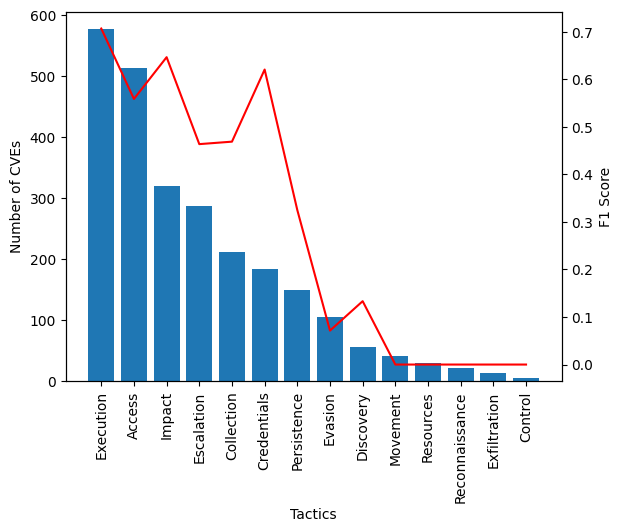

In [41]:
print_F1_based_on_distribution(BEST_PREDICTED, BEST_TRUE, y_train_df,  df_test.columns[2:])